<a href="https://colab.research.google.com/github/jjyjung/ai_mfg/blob/main/%ED%9A%8C%EC%A0%84%EA%B8%B0%EA%B3%84_%EA%B3%A0%EC%9E%A5%EC%A7%84%EB%8B%A8_ML%EC%8B%A4%EC%8A%B5_v8_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **회전기계 고장진단 실습**

회전기계에서 수집된 진동센서 데이터를 전처리한 후, 머신러닝 기법을 이용하여 회전기계의 고장 여부를 판단하는 문제입니다.

본 자료는 아래의 KAMP(한국인공지능제조플랫폼) 데이터를 활용하였고, 교육용 머신러닝 코드를 새롭게 추가하였습니다.

 https://www.kamp-ai.kr/aidataDetail?DATASET_SEQ=18

* Rotor testbed를 이용하여 여러 고장 유형에 대한 특징을 분석하고 정상 및 고장 유형을 분류하는 기술을 개발합니다.
* 많은 산업 현장에서 사용되는 회전 설비의 고장을 분석하고 진단하는 예제로, 이를 확장하여 실제 자동화 라인에 적용할 수 있습니다.

![fig.01.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fig.01.png?raw=true&style=centerme)<br>

- 본 Rotor testbed의 사양은 다음과 같습니다.

|    구분    |                 사양                 |
|:----------:|:------------------------------------:|
| Size       | 673 mm (W) x 280 mm (D) x 281 mm (H) |
| Weight     |                 25kg                 |
| Material   |               Aluminum               |
| Bearing    |             6202ZZ x 2EA             |
| Motor      |  DC 12V x 0.25 HP (0.2W), 0-3000 RPM  |
| Main power |                AC 220V               |

- 본 실험 데이터는 1 kHz의 진동 데이터(가속도)로 수집합니다. 즉, 1초에 1000개 데이터를 기록합니다.

| Rotor testbed |                   |
|:-------------:|:-----------------:|
| RPM           |     about 1500    |
| Sampling rate | 1 kHz (0.001 sec) |

## **1. 고장실험 데이터**

### 1-1. 고장 데이터 수집

- 총 4개의 센서를 사용하고 sensor1~sensor4로 명명한다.<br>
- 센서는 아래 그림의 빨간색 위치에 부착하였다.<br>
<br>

<center><img src = "https://github.com/jjyjung/ai_mfg/blob/main/img/sensor2.png?raw=true"><br>[센서 부착 위치 (빨간색)]</center> <br>

- 네 가지 상태(정상 및 고장유형 1, 2, 3)에 대하여 각각 140초씩 실험을 수행하여 데이터를 수집하였다.<br>
![fault_type.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fault_type.png?raw=true)<br>

| 구분   | 특징                                                |
|--------|-----------------------------------------------------|
| Type 1 | Disk 2에 회전 불균형 (270도 위치에 볼트, 너트 부착) |
| Type 2 | Support 4에 지지 불균형                             |
| Type 3 | Type 1 + Type 2                                     |


### 1-2. 고장 데이터 업로드

 * **[실습] Sensor 파일 4개 업로드**
  * 파일 링크: https://drive.google.com/drive/folders/1942hRbDFdSidXI999UUMjompB_teNR5l
  * csv 파일 2개를 Google Colab의 왼쪽에 있는 "파일" 영역에 Drag & Drop하여 업로드 하세요.

In [1]:
# 필요한 패키지(라이브러리) 로딩
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

# 4개 센서 데이터를 읽어들이기 위하여 아래 코드를 실행합니다.
dir = "/content/"
normal_ = pd.read_csv(dir+'rotor_normal.csv')
type1_ = pd.read_csv(dir+'rotor_type1.csv')
type2_ = pd.read_csv(dir+'rotor_type2.csv')
type3_ = pd.read_csv(dir+'rotor_type3.csv')

print('normal의 데이터 크기 :', normal_.shape)
print('type1의 데이터 크기 :', type1_.shape)
print('type2의 데이터 크기 :', type2_.shape)
print('type3의 데이터 크기 :', type3_.shape)

normal의 데이터 크기 : (140000, 5)
type1의 데이터 크기 : (140000, 5)
type2의 데이터 크기 : (140000, 5)
type3의 데이터 크기 : (140000, 5)


* 정상 상태(normal_)에서 수집된 데이터를 확인해봅시다.



In [2]:
normal_

,time,s1,s2,s3,s4
0,0.000,-0.853307,0.048823,-0.437626,-1.116226
1,0.001,-0.524588,-0.029477,-0.149817,-0.659694
2,0.002,-0.003708,-0.004751,0.280889,-0.857345
3,0.003,-0.297674,0.009673,-0.303281,-0.685318
4,0.004,-0.091203,0.096214,-0.320263,-0.303108
...,...,...,...,...,...
139995,139.995,-1.057411,0.587429,0.275044,0.289837
139996,139.996,-0.513635,-0.137874,-0.045973,0.131462
139997,139.997,-1.085213,0.002242,-0.164594,-0.087380
139998,139.998,-0.677177,-0.308897,0.288252,1.319862


* **[실습] 고장 상태(type1_, type2_, type3_)의 데이터도 확인해보세요.**

### 1-3. 데이터 분포 및 시각화

* 기술통계량
 * 평균(mean), 표준편차(max)
 * 최대값(min), 최대값(max)
 * 25%, 50%, 75% Percentile

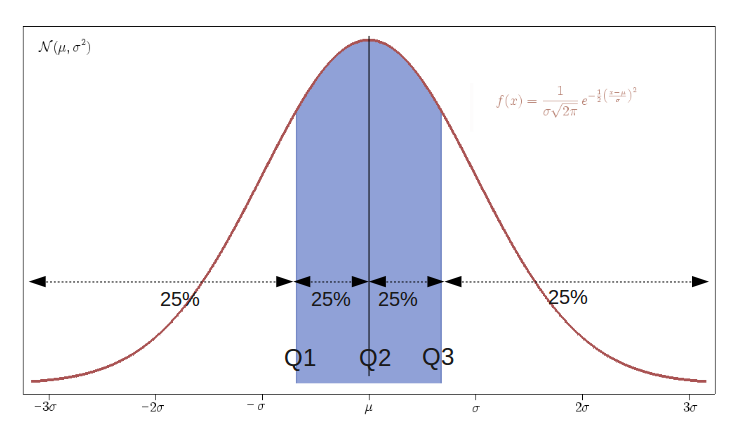

* 정상 상태(normal_)에서 센터들의 데이터 분포를 확인해봅시다.

In [3]:
normal_.describe()

,time,s1,s2,s3,s4
count,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000
mean,69.999500,0.000154,-0.000176,-0.000055,-0.000033
std,40.414663,0.662102,0.919906,0.289013,0.596637
min,0.000000,-1.977848,-3.269776,-1.855522,-2.379047
25%,34.999750,-0.603861,-0.708364,-0.173364,-0.433211
50%,69.999500,0.108722,0.061636,0.017206,-0.022380
75%,104.999250,0.578152,0.713594,0.191632,0.412691
max,139.999000,1.791827,3.218889,1.265529,2.172116


 * **[실습] 고장 상태(type1_, type2_, type3_)에서 센서들의 데이터 분포도 확인해보세요.**

In [4]:
type1_.describe()

,time,s1,s2,s3,s4
count,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000
mean,69.999500,-0.000147,0.000173,-0.000221,0.000039
std,40.414663,1.679021,1.440690,0.299679,0.550694
min,0.000000,-6.188363,-3.490567,-1.560514,-2.482690
25%,34.999750,-1.538706,-1.223964,-0.184295,-0.366186
50%,69.999500,-0.022895,-0.423887,0.011185,0.017278
75%,104.999250,1.565662,1.324872,0.193409,0.386281
max,139.999000,6.327469,4.807401,1.349805,2.360600


* **히스토그램(histograph)**

Index(['s1', 's2', 's3', 's4'], dtype='object')


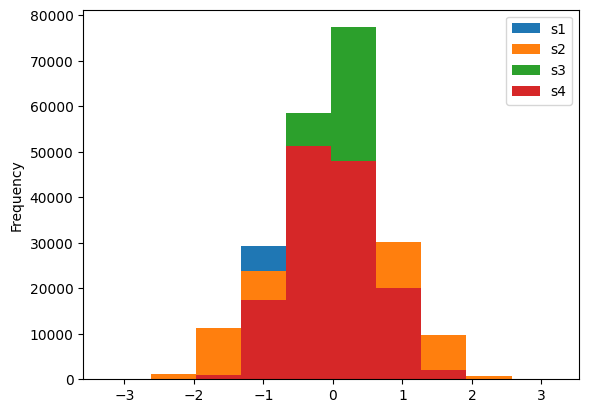

In [5]:
print(normal_.columns[1:])

normal_.plot(kind='hist', y=normal_.columns[1:])
plt.show()

* **밀도 그래프(density plot)**

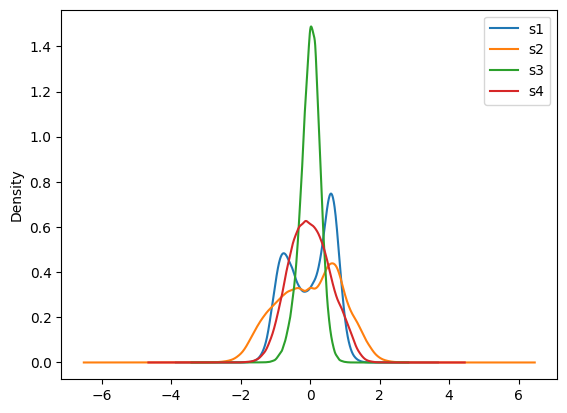

In [6]:
normal_.plot(kind='density', y=normal_.columns[1:])
plt.show()

  * **[질문] 데이터를 이해하는데 어떤 그래프가 적절한가요?**
  * **[실습] 고장 상태(type1_, type2_, type3_)에서 센서들의 데이터 분포도 해보세요.**

### 1-4. 데이터 시각화(시계열)
* 수집된 데이터는 4가지 상태에서 140초 동안에 4개 센서로 수집된 시계열 데이터입니다.
* 아래는 4가지 상태(normal, type1, type2, type3)에서 Sensor 1(s1)의 신호를 시계열 그래프로 보여줍니다.

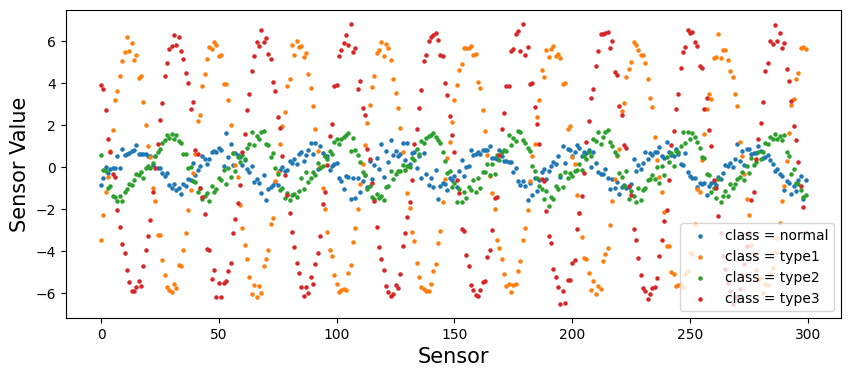

In [7]:
# 초기 300개의 시계열 가시화하는 함수
def draw_time_series(ss):
    plt.figure(figsize = (10, 4))
    plt.scatter(range(0,300), normal_[ss][:300], label="class = normal", marker='o', s=5)
    plt.scatter(range(0,300), type1_[ss][:300], label="class = type1", marker='o', s=5)
    plt.scatter(range(0,300), type2_[ss][:300], label="class = type2", marker='o', s=5)
    plt.scatter(range(0,300), type3_[ss][:300], label="class = type3", marker='o', s=5)

    plt.legend(loc="lower right")
    plt.xlabel("Sensor", fontsize=15)
    plt.ylabel("Sensor Value", fontsize=15)
    plt.show()
    plt.close()

# 센서 1의 그래프 가시화
draw_time_series('s1')

* 아래는 Sensor 2, Sensor 3, Sensor 4의 그래프도 그려보시오.

* **[질문] 네 가지 센서 중에서 어떤 센서가 고장 진단에 가장 유용할 것으로 예상되나요?**

## **2. 데이터 전처리**

### 2-1. 데이터 선별

* 가동 초기(여기에서는 30초)의 데이터를 탈락시키고(warm-up 시간), 이후의 안정적인 상태 데이터(steady state)를 분석에 사용합니다.
* 본 예제에서는 140초 중 30초 이후부터 100초 동안의 데이터를 (100000, 4)로 추출합니다.

In [8]:
normal = normal_[30000:130000][:]
type1  = type1_[30000:130000][:]
type2  = type2_[30000:130000][:]
type3  = type3_[30000:130000][:]

print('normal data size = ', normal.shape)

normal data size =  (100000, 5)


### 2-2. 데이터 분할

* 공정한 평가를 위하여 Normal, type1, type2, type3 데이터를 학습용(training data)과 테스트용(test data)으로 나누어야 합니다.
* 본 예제에서는 학습용 : 테스트용 데이터를 7:3 으로 분할합니다.

In [9]:
# 데이터 분할
normal_train = normal[:][:70000]; normal_test = normal[:][70000:]
type1_train  = type1[:][:70000];  type1_test  = type1[:][70000:]
type2_train  = type2[:][:70000];  type2_test  = type2[:][70000:]
type3_train  = type3[:][:70000];  type3_test  = type3[:][70000:]

### 2-3. 통계치 추출

* 일반적인 머신러닝 모형에 100,000개나 되는 시계열 데이터를 직접 입력하면 학습이 잘 되지 않기 때문에, 시계열 데이터의 통계적 지표(SI)를 추출하여 입력으로 사용할 수 있습니다.
* 본 예제에서는 1초를 모니터링 구간으로 설정하고, 각 구간에서 평균, 표준편차의 2가지 통계치를 추출하여 사용해봅시다.

In [10]:
# 통계적 지표(SI) 함수 정의
def get_mean(x):
    avg = np.mean(x)
    return(avg)

def get_std(x):
    std = np.std(x)
    return(std)

def make_df(x, sensor_num):
    mean_value = np.apply_along_axis(get_mean, 1, x)
    std_value = np.apply_along_axis(get_std, 1, x)
    df = pd.DataFrame({'mean_'+sensor_num:mean_value, 'std_'+sensor_num:std_value})
    return(df)

# 1초 구간으로 분할하여 SI를 측정하는 함수 정의
def generate_data(data):
  data = pd.DataFrame(data)
  df = pd.DataFrame()
  i = 0
  window_len = 1000  # 1초 (1000개)
  while data.shape[0] >= window_len:
    input = data.iloc[window_len*i:window_len*(i+1),:]
    input_arr = np.array(input).reshape((1,-1))
    df = pd.concat([df, pd.DataFrame(input_arr)], axis=0)
    data = data.iloc[window_len*(i+1):,:]

  df = df.reset_index(drop=True)
  return df


def extract_SI(data):
  s1_tmp = generate_data(data['s1'])
  s2_tmp = generate_data(data['s2'])
  s3_tmp = generate_data(data['s3'])
  s4_tmp = generate_data(data['s4'])

  s1_ext = make_df(s1_tmp, 's1')
  s2_ext = make_df(s2_tmp, 's2')
  s3_ext = make_df(s3_tmp, 's3')
  s4_ext = make_df(s4_tmp, 's4')

  df = pd.concat([s1_ext, s2_ext], axis=1)
  # df = pd.concat([s1_ext, s2_ext, s3_ext, s4_ext], axis=1)
  return df


# 분할 및 SI 측정하는 코드 실행
normal_train_ext = extract_SI(normal_train)
type1_train_ext = extract_SI(type1_train)
type2_train_ext = extract_SI(type2_train)
type3_train_ext = extract_SI(type3_train)

normal_test_ext = extract_SI(normal_test)
type1_test_ext = extract_SI(type1_test)
type2_test_ext = extract_SI(type2_test)
type3_test_ext = extract_SI(type3_test)

# Normal, Type1, Type2, Type3 데이터의 클래스를 각각 0, 1, 2, 3으로 라벨링 부여
normal_train_ext_labeled = np.append(normal_train_ext, np.repeat(0, normal_train_ext.shape[0]).reshape(normal_train_ext.shape[0], 1), axis=1)
type1_train_ext_labeled = np.append(type1_train_ext, np.repeat(1, type1_train_ext.shape[0]).reshape(type1_train_ext.shape[0], 1), axis=1)
type2_train_ext_labeled = np.append(type2_train_ext, np.repeat(2, type2_train_ext.shape[0]).reshape(type2_train_ext.shape[0], 1), axis=1)
type3_train_ext_labeled = np.append(type3_train_ext, np.repeat(3, type3_train_ext.shape[0]).reshape(type3_train_ext.shape[0], 1), axis=1)

normal_test_ext_labeled = np.append(normal_test_ext, np.repeat(0, normal_test_ext.shape[0]).reshape(normal_test_ext.shape[0], 1), axis=1)
type1_test_ext_labeled = np.append(type1_test_ext, np.repeat(1, type1_test_ext.shape[0]).reshape(type1_test_ext.shape[0], 1), axis=1)
type2_test_ext_labeled = np.append(type2_test_ext, np.repeat(2, type2_test_ext.shape[0]).reshape(type2_test_ext.shape[0], 1), axis=1)
type3_test_ext_labeled = np.append(type3_test_ext, np.repeat(3, type3_test_ext.shape[0]).reshape(type3_test_ext.shape[0], 1), axis=1)

combined_trn = np.concatenate((normal_train_ext_labeled, type1_train_ext_labeled, type2_train_ext_labeled, type3_train_ext_labeled))
combined_test = np.concatenate((normal_test_ext_labeled, type1_test_ext_labeled, type2_test_ext_labeled, type3_test_ext_labeled))

# 골고루 학습하고 테스트하기 위하여, 학습 및 평가 데이터들에 Shuffling을 수행
np.random.shuffle(combined_trn)
np.random.shuffle(combined_test)

## **3. 모델 학습 및 평가**



###3-1. 의사결정나무 (Decision Tree)
* 의사결정나무(DT: Decision Tree)는 변수의 값에 따라 분할하는 규칙을 순차적으로 적용하여 데이터를 분류하는 기법

 ![dt_table.png](https://av-eks-blogoptimized.s3.amazonaws.com/905753.png)
 ![dt_table.png](https://av-eks-blogoptimized.s3.amazonaws.com/542834.png)

* 성능 평가 함수 (여러 모델 공통)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_pred):
  accuracy = accuracy_score(combined_test[:,-1], y_pred)
  precision = precision_score(combined_test[:,-1], y_pred, average='weighted')
  recall = recall_score(combined_test[:,-1], y_pred, average='weighted')
  f1 = f1_score(combined_test[:,-1], y_pred, average='weighted')
  print('Accuracy: ', "%.2f" % (accuracy*100))
  print('Precision: ', "%.2f" % (precision*100))
  print('Recall: ', "%.2f" % (recall*100))
  print('F1: ', "%.2f" % (f1*100))

  # Confusion Matrix 생성
  Confusion_Matrix = confusion_matrix(combined_test[:,-1], y_pred)

  cm_df = pd.DataFrame(Confusion_Matrix,
                      index = ['normal','type1','type2','type3'],
                      columns = ['normal','type1','type2','type3'])

  #Plotting the confusion matrix
  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

* 모델 학습 및 평가 (Decision Tree)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................

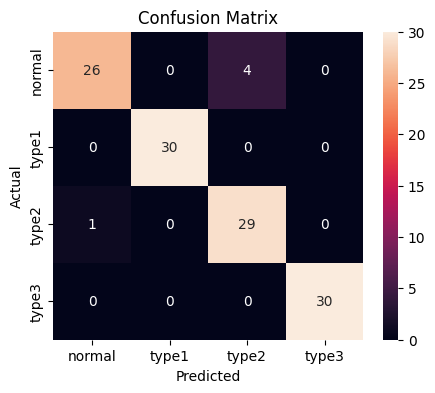

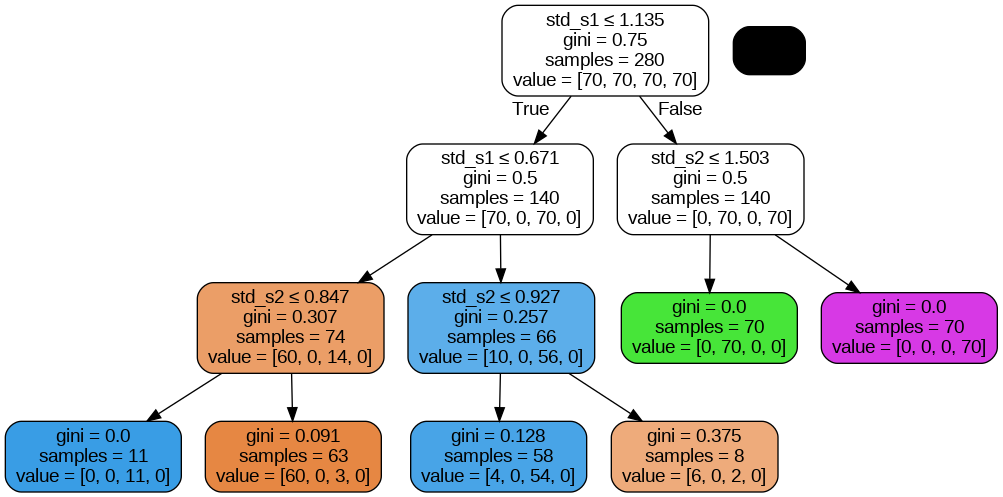

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


# 모델 학습
dt_model = DecisionTreeClassifier()

param_dist = {"max_depth": [3, 5, 7]}

tuned_dt = GridSearchCV(dt_model, param_grid=param_dist, verbose=2, refit=True)
tuned_dt.fit(combined_trn[:,:-1], combined_trn[:,-1])


# 최적 파라미터 출력
print(tuned_dt.best_params_)


# 성능 평가
y_pred = tuned_dt.predict(combined_test[:,:-1])
show_confusion_matrix(y_pred)


# Decision Tree 그리기
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

x_list = list(normal_train_ext.columns)
dot_data = export_graphviz(tuned_dt.best_estimator_, out_file=None, feature_names=x_list,
                          filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

**[결과 확인]**
* 어떤 경우에 장비의 상태를 잘못 감지하는가?

* 의사결정나무는 어떤 기준으로 고장을 감지하는가?


### 3-2. 랜덤 포레스트 (Random Forest)
* 랜덤 포레스트(RF: Random Forest)는 훈련 데이터에서 복원 추출하여 생성한 다수의 데이터셋으로부터 다수의 의사결정나무(Decision Tree)를 학습시킨 후, 다수의 의사결정나무의 예측값의 평균으로 최종 예측하는 분류 또는 회귀 기법

<img src="https://miro.medium.com/v2/resize:fit:1010/1*R3oJiyaQwyLUyLZL-scDpw.png" width="50%">

* 모델 학습 및 성능 평가 (Random Forest)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'max_depth': 10, 'n_estimators': 100}
Accuracy:  96.67
Precision:  96.76
Recall:  96.67
F1:  96.66


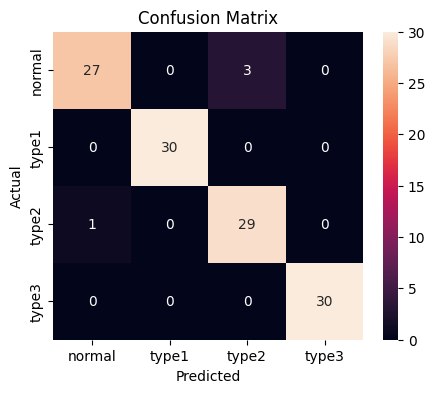

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
RF_model = RandomForestClassifier()

param_dist = {"n_estimators": [100, 200],
              "max_depth": [3, 5, 10]}

tuned_rf = GridSearchCV(RF_model, param_grid=param_dist, verbose=1, refit=True)
tuned_rf.fit(combined_trn[:,:-1], combined_trn[:,-1])

# 최적 파라미터 값
print(tuned_rf.best_params_)


# 성능 평가
y_pred = tuned_rf.predict(combined_test[:,:-1])
show_confusion_matrix(y_pred)

**[결과 확인]**
* 어떤 경우에 장비의 상태를 오감지 하는가?

**[모형 개선 방안]**
* 위 실험 설계에서 모형의 고장감지 성능을 더 향상시키기 위한 방법은 어떤 것이 있을까?

## **4. 추가 논의**

**[실습1] 센서 선정**

센서 하나만 사용한다면 몇 번 센서를 사용하는 것이 좋을까?


**[실습2] 통계치 선정**

 어떤 통계치를 사용하는 것이 가장 우수한가?


**[실습3] 최소 비용**

센서 및 데이터수집기(DAQ)의 가격을 절감하고자 한다. 최소 비용으로 구축하려면 어떻게 하면 좋을까?

